# Importing a SimaPro CSV that includes ecoinvent

This notebook shows how to import a SimaPro CSV export that includes ecoinvent 2.2. We will use a custom strategy to remove the ecoinvent processes, and then link to the ecoinvent already present on our machine.

In [1]:
from brightway2 import *

## Basic setup

Start a new project, and install base data

In [2]:
projects.current = "world-food"

In [3]:
bw2setup()

Creating default biosphere

Applying strategy: drop_unspecified_subcategories

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 0.359 sec



Title: Writing activities to SQLite3 database:
  Started: 05/21/2015 12:06:32
  Finished: 05/21/2015 12:06:32
  Total time elapsed: 0.359 sec
  CPU %: 95.000000
  Memory %: 0.258434
Created database: biosphere3
Creating default LCIA methods

Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Wrote 692 LCIA methods with 170915 characterization factors
Creating core data migrations



## Import ecoinvent 2.2

In [3]:
ei22 = SingleOutputEcospold1Importer(
    "/Users/cmutel/Documents/LCA Documents/Ecoinvent/2.2/processes",
    "ecoinvent 2.2"
)
ei22.apply_strategies()
ei22.write_database()

Extracting ecospold1 files:
0%                          100%
[##############################] | ETA[sec]: 0.000 | Item ID: /Users/cmutel/D
Total time elapsed: 5.015 sec


Title: Extracting ecospold1 files:
  Started: 10/22/2015 09:40:33
  Finished: 10/22/2015 09:40:38
  Total time elapsed: 5.015 sec
  CPU %: 100.000000
  Memory %: 0.809336
Extracted 4087 datasets in 5.02 seconds
Applying strategy: normalize_units
Applying strategy: assign_only_product_as_production
Applying strategy: clean_integer_codes
Applying strategy: drop_unspecified_subcategories
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: link_technosphere_by_activity_hash
Applied 10 strategies in 2.27 seconds

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 9.640 sec



Title: Writing activities to SQLite3 database:
  Started: 10/22/2015 09:40:40
  Finished: 10/22/2015 09:40:50
  Total time elapsed: 9.640 sec
  CPU %: 92.700000
  Memory %: 0.858426
Created database: ecoinvent 2.2


Brightway2 SQLiteBackend: ecoinvent 2.2

## Load SimaPro CSV export

In [3]:
sp = SimaProCSVImporter("/Users/cmutel/Downloads/WFLDB2.0_v3.CSV", "world-food")

ValueError: Parameter label yield not a valid Python name

Change all variables names "yield" (and "Yield") to "yield_"; "yield" is a python reserved word.

In [3]:
sp = SimaProCSVImporter("/Users/cmutel/Downloads/WFLDB2.0_v3-yield.CSV", "world-food")

Extracted 568 unallocated datasets in 1.98 seconds


## Internal linking

Apply strategies to get data into a the normal state, and link internal flows:

In [4]:
sp.apply_strategies()
sp.statistics()

Applying strategy: normalize_units
Applying strategy: normalize_simapro_product_units
Applying strategy: assign_only_product_as_production
Applying strategy: drop_unspecified_subcategories
Applying strategy: sp_allocate_products
Applying strategy: split_simapro_name_geo
Applying strategy: strip_biosphere_exc_locations
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: link_technosphere_based_on_name_unit_location
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_simapro_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: normalize_simapro_biosphere_names
Applying strategy: link_iterable_by_fields
Applied 15 strategies in 2.21 seconds
610 datasets
104650 exchanges
4903 unlinked exchanges
  Type biosphere: 162 unique unlinked exchanges
  Type technosphere: 438 unique unlinked exchanges


(610, 104650, 4903)

## Unit conversions

To match against ecoinvent using the ``unit`` field, we need to have everything in the right units. We accomplish this by applying migrations that converts units to ecoinvent defaults.

In [5]:
sp.migrate('unusual-units')
sp.migrate('default-units')

Applying strategy: migrate_datasets
Applied 1 strategies in 0.00 seconds
Applying strategy: migrate_exchanges
Applied 1 strategies in 0.28 seconds
Applying strategy: migrate_datasets
Applied 1 strategies in 0.00 seconds
Applying strategy: migrate_exchanges
Applied 1 strategies in 0.28 seconds


## Link to ecoinvent 2.2:

In [6]:
sp.match_database("ecoinvent 2.2", ignore_categories=True)
sp.statistics()

Applying strategy: link_iterable_by_fields
610 datasets
104650 exchanges
798 unlinked exchanges
  Type biosphere: 162 unique unlinked exchanges
  Type technosphere: 24 unique unlinked exchanges


(610, 104650, 798)

## What is still unlinked?

There are some flows specific to SimaPro that we can't match perfectly yet. Let's look at what we still have to do.

First, export only the unlinked exchanges:

In [7]:
sp.write_excel(only_unlinked=True)

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/world-food.700303a19dddb90e1b8b5c6d60da3131/export/db-matching-world-food-unlinked.xlsx


Then the entire database, to see what the names, categories, or units should be:

In [8]:
sp.write_excel()

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/world-food.700303a19dddb90e1b8b5c6d60da3131/export/db-matching-world-food.xlsx


# Fixing ``Water, BR``

Biosphere flows occur in the location their processes do, and don't need country codes. The mangling in the database file comes from SimaPro not being agle to do regionalization yet.

We can define a new strategy to remove these country codes:

In [9]:
import re

def remove_country_codes(db):
    expressions = [
        re.compile("^Water, [A-Z]{2}$"),
        re.compile("^Water, river, [A-Z]{2}$"),
        re.compile("^Water, well, in ground, [A-Z]{2}$"),
    ]
    pattern = ", [A-Z]{2}$"
    for ds in db:
        for exc in ds.get('exchanges', []):
            if exc.get('input') or not exc['type'] == 'biosphere':
                continue
            for expression in expressions:
                if expression.match(exc['name']):
                    exc['name'] = re.sub(", [A-Z]{2}$", "", exc['name'])
    return db

In [10]:
sp.apply_strategy(remove_country_codes)
sp.match_database("biosphere3", kind='biosphere')
sp.statistics()

Applying strategy: remove_country_codes
Applying strategy: link_iterable_by_fields
610 datasets
104650 exchanges
713 unlinked exchanges
  Type biosphere: 99 unique unlinked exchanges
  Type technosphere: 24 unique unlinked exchanges


(610, 104650, 713)

# Fix some process  and biosphere flow names and categories

We define two separates ``migration``s to fix some incorrect data.

In [11]:
biosphere_units_data = {
    'fields': ['name', 'unit'],
    'data': [
        (
            ('Water, cooling, unspecified natural origin/kg', 'kilogram'), 
            {
                'name': 'Water, cooling, unspecified natural origin',
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Sodium sulphate', 'kilogram'), 
            {'name': 'Sodium sulphate, various forms, in ground'}
        ),
        (
            ('Occupation, industrial area', 'square meter-year'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            ('Carbon dioxide, in air', 'kilogram'), 
            {'categories': ('natural resource', 'in air')}
        ),
        (
            ('Glyphosate', 'kilogram'), 
            {'categories': ('soil', 'agricultural')}
        ),
        (
            ('Occupation, permanent crop', 'square meter-year'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            ('Occupation, industrial area', 'square meter-year'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            ('Occupation, construction site', 'square meter-year'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            # Typo in discontinuously - how???
            ('transformation, to urban, discontinously built', 'square meter'), 
            {'name': 'Transformation, to urban, discontinuously built'}
        ),
        (
            ('wood, primary forest, standing', 'square meter'), 
            {'categories': ('natural resource', 'biotic')}
        ),
        (
            ('Water, river', 'cubic meter'), 
            {'categories': ('natural resource', 'in water')}
        ),
        (
            ('Water, unspecified natural origin', 'cubic meter'), 
            {'categories': ('natural resource', 'in water')}
        ),
        (
            ('Water, well, in ground', 'cubic meter'), 
            {'categories': ('natural resource', 'in water')}
        ),
        (
            ('transformation, from permanent crop', 'square meter'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            ('transformation, to permanent crop', 'square meter'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            ('Methane', 'kilogram'), 
            {'name': 'Methane, fossil'}
        ),
        (
            ('Wood, primary forest, standing', 'cubic meter'), 
            {'categories': ('natural resource', 'biotic')}
        ),
        (
            ('Water, cooling, well, in ground', 'kilogram'), 
            {
                'name': 'Water, well, in ground',
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Water, well, in ground', 'litre'), 
            {
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Water, river', 'litre'), 
            {
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Treatment, sewage, to wastewater treatment, class 4', 'litre'), 
            {
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Solved solids', 'kilogram'), 
            {'name': 'Dissolved solids'}  # ???
        ),  
        (
            ('Water, unspecified natural origin/m3', 'cubic meter'), 
            {
                'name': 'Water, unspecified natural origin',
                'categories': ('natural resource', 'in water')
            }
        ),
        (
            ('Transformation, to arable land, unspecified use', 'square meter'), 
            {'categories': ('natural resource', 'land')}  # Was "in ground"?
        ),
        (
            ('Transformation, from arable land, unspecified use', 'square meter'), 
            {'categories': ('natural resource', 'land')}
        ),
        (
            ('Water, river', 'litre'), 
            {
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Water, well, in ground', 'litre'), 
            {
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
        (
            ('Water', 'kilogram'), 
            {
                'unit': 'cubic meter', 
                'multiplier': 1e-3
            }
        ),
    ]
}

biosphere_units_migration = Migration(
    "food-migration-biosphere-units" 
)
biosphere_units_migration.write(
    biosphere_units_data,
    description="Fix biosphere units and categories from World Food database"
)

In [12]:
sp.migrate("food-migration-biosphere-units")
sp.match_database("biosphere3", kind='biosphere')
sp.statistics()

Applying strategy: migrate_datasets
Applied 1 strategies in 0.00 seconds
Applying strategy: migrate_exchanges
Applied 1 strategies in 0.33 seconds
Applying strategy: link_iterable_by_fields
610 datasets
104650 exchanges
294 unlinked exchanges
  Type biosphere: 69 unique unlinked exchanges
  Type technosphere: 24 unique unlinked exchanges


(610, 104650, 294)

In [13]:
food_technosphere_migration_data = {
    'fields': ['name', 'unit'],
    'data': [
        (
            ('Tied housing system, cattle', 'unit'),
            {'unit': 'livestock unit'}
        ),
        (
            ('Loose housing system, cattle', 'unit'),
            {'unit': 'livestock unit'}
        ),
        (
            ('Water supply network', 'meter'),
            {
                'unit': 'kilometer',
                'multiplier': 0.001
            }
        ),
        (
            ('Transmission network, long-distance', 'meter'),
            {
                'unit': 'kilometer',
                'multiplier': 0.001
            }
        ),
        (
            ('Distribution network, electricity, low voltage', 'meter'),
            {
                'unit': 'kilometer',
                'multiplier': 0.001
            }
        ),
        (
            ('Transmission network, electricity, medium voltage', 'meter'),
            {
                'unit': 'kilometer',
                'multiplier': 0.001
            }
        ),
        (
            ('Transmission network, electricity, high voltage', 'meter'),
            {
                'unit': 'kilometer',
                'multiplier': 0.001
            }
        ),
        (
            ('Electricity, low voltage, production RER, at grid', 'megajoule'),
            {
                'unit': 'kilowatt hour',
                'multiplier': 1/3.6
            }
        ),
        (
            ('Electricity, medium voltage, production UCTE, at grid', 'megajoule'),
            {
                'unit': 'kilowatt hour',
                'multiplier': 1/3.6
            }
        ),
        (
            ('Electricity, medium voltage, at grid', 'megajoule'),
            {
                'unit': 'kilowatt hour',
                'multiplier': 1/3.6
            }
        ),
        (
            ('Electricity mix', 'megajoule'),
            {
                'unit': 'kilowatt hour',
                'multiplier': 1/3.6
            }
        ),
        (
            ('Refinery gas, burned in furnace/MJ', 'megajoule'), 
            {'name': 'refinery gas, burned in furnace'}
        ),
    ]
}

food_technosphere_migration = Migration("food-technosphere")
food_technosphere_migration.write(
    food_technosphere_migration_data, 
    description="Specific technosphere fixes for World Food DB"
)

In [14]:
sp.migrate("food-technosphere")
sp.match_database("ecoinvent 2.2", ignore_categories=True)
sp.statistics()

Applying strategy: migrate_datasets
Applied 1 strategies in 0.00 seconds
Applying strategy: migrate_exchanges
Applied 1 strategies in 0.33 seconds
Applying strategy: link_iterable_by_fields
610 datasets
104650 exchanges
226 unlinked exchanges
  Type biosphere: 69 unique unlinked exchanges
  Type technosphere: 11 unique unlinked exchanges


(610, 104650, 226)

In [15]:
sp.write_excel(only_unlinked=True)

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/world-food.700303a19dddb90e1b8b5c6d60da3131/export/db-matching-world-food-unlinked.xlsx


# Acceptance

The missing flows and technosphere processes are truly missing - they have no analogue in ecoinvent or our biosphere flow list. We can then add the missing activities and biosphere flows, and write the database. Here is a screenshot of the missing links; the full file can also be downloaded at https://bitbucket.org/cmutel/brightway2/src/tip/notebooks/files/?at=2.0 (click on "view raw" to download).

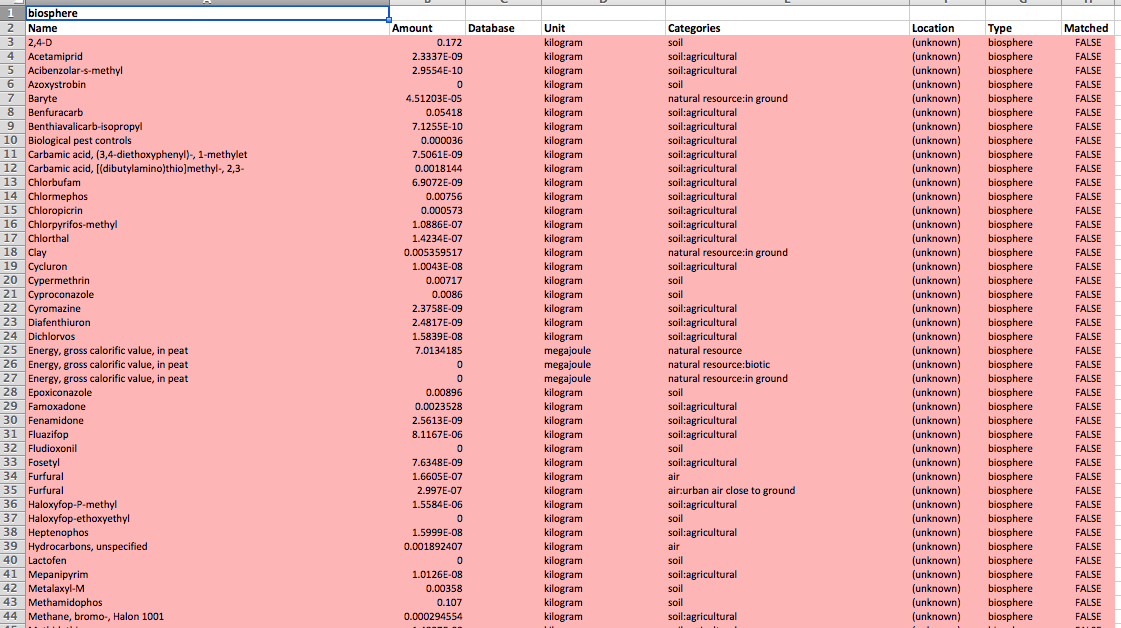

In [19]:
from IPython.display import Image
Image(filename='files/food-unlinked-selection.png') 

In [16]:
sp.add_unlinked_flows_to_biosphere_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 0.402 sec


Title: Writing activities to SQLite3 database:
  Started: 10/22/2015 15:27:49
  Finished: 10/22/2015 15:27:49
  Total time elapsed: 0.402 sec
  CPU %: 76.400000
  Memory %: 0.886989
Applying strategy: link_iterable_by_fields


In [17]:
sp.add_unlinked_activities()

Applying strategy: link_iterable_by_fields


In [18]:
sp.statistics()

621 datasets
104650 exchanges
0 unlinked exchanges
  


(621, 104650, 0)

In [20]:
sp.write_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 6.102 sec


Title: Writing activities to SQLite3 database:
  Started: 10/22/2015 15:36:08
  Finished: 10/22/2015 15:36:14
  Total time elapsed: 6.102 sec
  CPU %: 91.700000
  Memory %: 0.916708
Created database: world-food


Brightway2 SQLiteBackend: world-food